In [1]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.base import clone
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings

matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')
SEED = 27

In [2]:
dataset = pd.read_csv("/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv")
dataset = dataset.dropna(subset=['lønn'])

In [3]:
dataset

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
...,...,...,...,...,...,...,...,...,...,...
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja


# Top 10 best betalte

In [4]:
dataset.sort_values(by="lønn", ascending=False).head(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
2305,46-50,5.0,22.0,"in-house, privat sektor",Oslo,ledelse/administrativt,100 - 500,3500000.0,Ja,Ja
2304,31-35,5.0,9.0,frilans / selvstendig næringsdrivende,Rogaland,fullstack,over 10.000,3000000.0,Nei,Ja
2303,41-45,5.0,20.0,frilans / selvstendig næringsdrivende,Oslo,backend,under 10,2950000.0,Nei,Ja
2302,41-45,5.0,17.0,"in-house, privat sektor",Oslo,embedded/IOT/maskinvare,1.000 - 10.000,2950000.0,Ja,Ja
2301,46-50,3.0,25.0,frilans / selvstendig næringsdrivende,Viken,arkitektur,under 10,2500000.0,Nei,Ja
2300,36-40,5.0,12.0,"in-house, privat sektor",Oslo,ledelse/administrativt,over 10.000,2500000.0,Ja,Ja
2299,26-30,5.0,5.0,frilans / selvstendig næringsdrivende,utlandet,sikkerhet,50 - 100,2500000.0,Ja,Ja
2298,51-55,3.0,29.0,konsulent,Oslo,fullstack,10 - 50,2500000.0,Ja,Ja
2297,31-35,3.0,10.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,2330000.0,Nei,Ja
2295,26-30,3.0,5.0,frilans / selvstendig næringsdrivende,Oslo,fullstack,under 10,2300000.0,Nei,Ja


# Top 10 dårlegast betalte

In [5]:
dataset.sort_values(by="lønn", ascending=False).tail(10)

,alder,utdanning,erfaring,jobb,sted,fag,kolleger,lønn,bonus,fornøyd
7,15-20,1.0,0.0,"in-house, privat sektor",Trøndelag,programvare,10 - 50,360000.0,Nei,Nei
10,21-25,0.0,4.0,konsulent,Viken,app,under 10,360000.0,Nei,Nei
11,46-50,NaN,32.0,"in-house, privat sektor",Innlandet,ledelse/administrativt,under 10,360000.0,Ja,Nei
6,26-30,0.0,1.0,"in-house, privat sektor",Troms og Finnmark,fullstack,10 - 50,352000.0,Nei,Nei
3,26-30,NaN,3.0,frilans / selvstendig næringsdrivende,Oslo,frontend,under 10,350000.0,Ja,Nei
2,31-35,3.0,14.0,"in-house, privat sektor",Viken,ingen av disse,100 - 500,350000.0,Nei,Nei
1,26-30,0.0,1.0,"in-house, privat sektor",Innlandet,fullstack,100 - 500,350000.0,Nei,Nei
4,31-35,4.0,0.0,"in-house, privat sektor",Viken,fullstack,under 10,350000.0,Nei,Nei
5,36-40,NaN,10.0,frilans / selvstendig næringsdrivende,Vestland,ingen av disse,under 10,350000.0,Nei,Nei
0,21-25,2.0,5.0,"in-house, privat sektor",Oslo,sikkerhet,100 - 500,350000.0,Ja,Ja


# Best betalte stillinger

In [6]:
avg_salaries_by_job_type = dataset.groupby('fag')['lønn'].mean().reset_index().sort_values(by="lønn", ascending=True)

fig = px.bar(
    avg_salaries_by_job_type,
    y='fag', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'fag': 'Fag', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_job_type.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['fag'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [7]:
avg_salary_by_fag = dataset.groupby('fag')['lønn'].mean().reset_index()
sorted_fag = avg_salary_by_fag.sort_values(by='lønn', ascending=True)['fag']
dataset_sorted = dataset.set_index('fag').loc[sorted_fag].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='fag',    
    width=800, 
    height=400
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Fag',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Kvar lønnar det seg å jobbe?

In [8]:
avg_salaries_by_city = dataset.groupby('sted')['lønn'].mean().reset_index().sort_values(by="lønn", ascending=True)

fig = px.bar(
    avg_salaries_by_city,
    y='sted', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'sted': 'Stad', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Fag',
    width=800,
    height=400,
    font=dict(size=10)
)

for i, row in avg_salaries_by_city.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['sted'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [9]:
avg_salary_by_city = dataset.groupby('sted')['lønn'].mean().reset_index()
sorted_city = avg_salary_by_city.sort_values(by='lønn', ascending=True)['sted']
dataset_sorted = dataset.set_index('sted').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='sted',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Stad',      
    xaxis_range=[0, 2_400_000], 
    font=dict(size=10)
)

fig.show()

# Erfaring og utdanning

In [10]:
cleaned_data = dataset.dropna(subset=['erfaring', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_experience = cleaned_data.groupby('erfaring')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmin()]
highest_point = avg_salary_by_experience.loc[avg_salary_by_experience['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_experience,
    x='erfaring',
    y='lønn',
    labels={'erfaring': 'Erfaring', 'lønn': 'Gjennomsnittsløn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['erfaring']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Erfaring: {int(lowest_point["erfaring"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['erfaring']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Erfaring: {int(highest_point["erfaring"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top center'
    )
)

fig.update_layout(
    xaxis_title="Erfaring",
    yaxis_title="Gjennomsnittsløn (NOK)",
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

In [11]:
cleaned_data = dataset.dropna(subset=['utdanning', 'lønn'])
cleaned_data['lønn'] = cleaned_data['lønn'].astype(float)
avg_salary_by_edu = cleaned_data.groupby('utdanning')['lønn'].mean().reset_index()
lowest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmin()]
highest_point = avg_salary_by_edu.loc[avg_salary_by_edu['lønn'].idxmax()]

fig = px.line(
    avg_salary_by_edu,
    x='utdanning',
    y='lønn',
    labels={'utdanning': 'Utdanning', 'lønn': 'Gjennomsnittslønn (NOK)'}
)


fig.add_trace(
    go.Scatter(
        x=[lowest_point['utdanning']],
        y=[lowest_point['lønn']],
        mode='markers+text',
        marker=dict(color='red', size=10),
        name='Lågast løn',
        text=[f'Lågast løn: {lowest_point["lønn"]:,.0f} NOK, Utdanning: {int(lowest_point["utdanning"])} år'],
        textfont=dict(size=10, color='red'),
        textposition='bottom right'
    )
)
fig.add_trace(
    go.Scatter(
        x=[highest_point['utdanning']],
        y=[highest_point['lønn']],
        mode='markers+text',
        marker=dict(color='green', size=10),
        name='Høgest løn',
        text=[f'Høgast løn: {highest_point["lønn"]:,.0f} NOK, Utdanning: {int(highest_point["utdanning"])} år'],
        textfont=dict(size=10, color='green'),
        textposition='top left'
    )
)

fig.update_layout(
    xaxis_title="Utdanning",
    yaxis_title="Gjennomsnittsløn (NOK)",
    width=800,
    height=400,
    font=dict(size=10)
)

fig.update_layout(showlegend=False)
fig.show()

# Privat, offentleg, konsulent, eller frilans

In [12]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index().sort_values(by="lønn", ascending=True)

fig = px.bar(
    avg_salaries_by_employer,
    y='jobb', 
    x='lønn',  
    color='lønn',
    color_continuous_scale='RdYlGn',
    labels={'jobb': 'Jobb', 'lønn': 'Gjennomsnittsløn (NOK)'}
)

fig.update_layout(
    xaxis_title='Gjennomsnittsløn (NOK)',
    yaxis_title='Jobb',
    width=800,
    height=400,
    font=dict(size=10)    
)

for i, row in avg_salaries_by_employer.iterrows():
    fig.add_annotation(
        x=row['lønn'],
        y=row['jobb'],
        text=f'{row["lønn"]:,.0f} NOK',
        showarrow=False,
        font=dict(color='black', size=10),
        xshift=-60 
    )

fig.update_coloraxes(showscale=False)
fig.show()


In [13]:
avg_salaries_by_employer = dataset.groupby('jobb')['lønn'].mean().reset_index()
sorted_city = avg_salaries_by_employer.sort_values(by='lønn', ascending=True)['jobb']
dataset_sorted = dataset.set_index('jobb').loc[sorted_city].reset_index()

fig = px.box(
    dataset_sorted,
    x='lønn',  
    y='jobb',    
    width=800, 
    height=400, 
)

fig.update_layout(
    xaxis_title='Løn (NOK)', 
    yaxis_title='Jobb',  
    font=dict(size=10)    
)

fig.show()

# Prediksjon av løn

In [14]:
dataset = pd.read_csv("/kaggle/input/lonn-data/kode24s_lonnstall_2023.csv")

In [15]:
dataset.isna().sum()

alder         1
utdanning    76
erfaring      3
jobb          0
sted          0
fag           0
kolleger      0
lønn         35
bonus         0
fornøyd       0
dtype: int64

In [16]:
dataset = dataset.dropna(subset=['lønn', 'alder'])
dataset['utdanning'] = dataset['utdanning'].fillna(dataset['utdanning'].mode()[0])
dataset['erfaring'] = dataset['erfaring'].fillna(dataset['erfaring'].mode()[0])   

In [17]:
dataset.isna().sum()

alder        0
utdanning    0
erfaring     0
jobb         0
sted         0
fag          0
kolleger     0
lønn         0
bonus        0
fornøyd      0
dtype: int64

In [18]:
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')
        dataset[col] = dataset[col].cat.codes

In [19]:
class Trainer:
    def __init__(self, model, X, y, n_splits=5, n_repeats=3):
        self.model = model
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.n_repeats = n_repeats

    def fit(self):
        skf = KFold(n_splits=self.n_splits, shuffle=True, random_state=SEED)
        
        oof_preds = np.zeros(len(self.X), dtype=float)
        scores = []
        for train_idx, val_idx in skf.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            
            y_pred = np.zeros_like(y_val, dtype=float)
            
            for i in range(self.n_repeats):
                m = clone(self.model)
                if self.n_repeats > 1:
                    m.set_params(random_state=i)
                m.fit(X_train, y_train)
                y_pred += m.predict(X_val)
                
            y_pred /= self.n_repeats
            
            score = r2_score(y_val, y_pred)
            scores.append(score)
            
            oof_preds[val_idx] = y_pred
            
        return scores, oof_preds
        
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test), dtype=float)
        for i in range(self.n_repeats):
            m = clone(self.model)
            if self.n_repeats > 1:
                m.set_params(random_state=i)
            m.fit(self.X, self.y)
            y_pred += m.predict(X_test)
        y_pred /= self.n_repeats
        return y_pred

In [20]:
models = [
    CatBoostRegressor(random_state=SEED, verbose=False),
    LGBMRegressor(random_state=SEED, verbose=-1),
    GradientBoostingRegressor(random_state=SEED),
    XGBRegressor(random_state=SEED, n_jobs=-1),
    HistGradientBoostingRegressor(random_state=SEED),
    ExtraTreesRegressor(random_state=SEED, n_jobs=-1),
]

X = dataset.drop(columns='lønn')
y = dataset['lønn']

In [21]:
model_scores = {}
model_preds = {}
for model in models:
    scores, preds = Trainer(model, X, y).fit()
    model_scores[model.__class__.__name__] = scores
    model_preds[model.__class__.__name__] = preds
    print(f'{model.__class__.__name__}: {np.mean(scores):.5f} ± {np.std(scores):.5f}')

CatBoostRegressor: 0.46273 ± 0.05562
LGBMRegressor: 0.44761 ± 0.06478
GradientBoostingRegressor: 0.49226 ± 0.04148
XGBRegressor: 0.37971 ± 0.07847
HistGradientBoostingRegressor: 0.44797 ± 0.06383
ExtraTreesRegressor: 0.37731 ± 0.06258


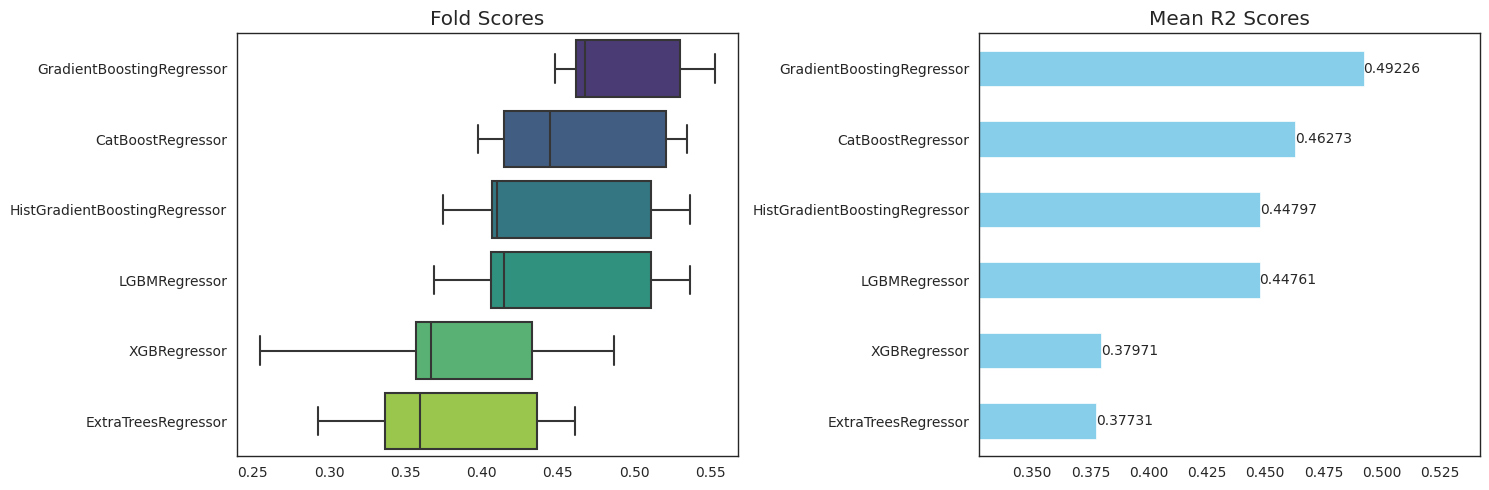

In [22]:
df = pd.DataFrame(model_scores)

sns.set_style("white") 
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=df, orient='h', palette='viridis', ax=axes[0], order=df.mean().sort_values(ascending=False).index.tolist())
axes[0].set_title('Fold Scores')
axes[0].set_xlabel('') 
axes[0].set_ylabel('')

mean_scores = df.mean().sort_values(ascending=True)
mean_scores.plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_title('Mean R2 Scores')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
for j, score in enumerate(mean_scores):
    axes[1].text(score, j, f'{score:.5f}', ha='left', va='center')
axes[1].set_xlim(mean_scores.min() - 0.05, mean_scores.max() + 0.05)
    
plt.tight_layout()
plt.show()

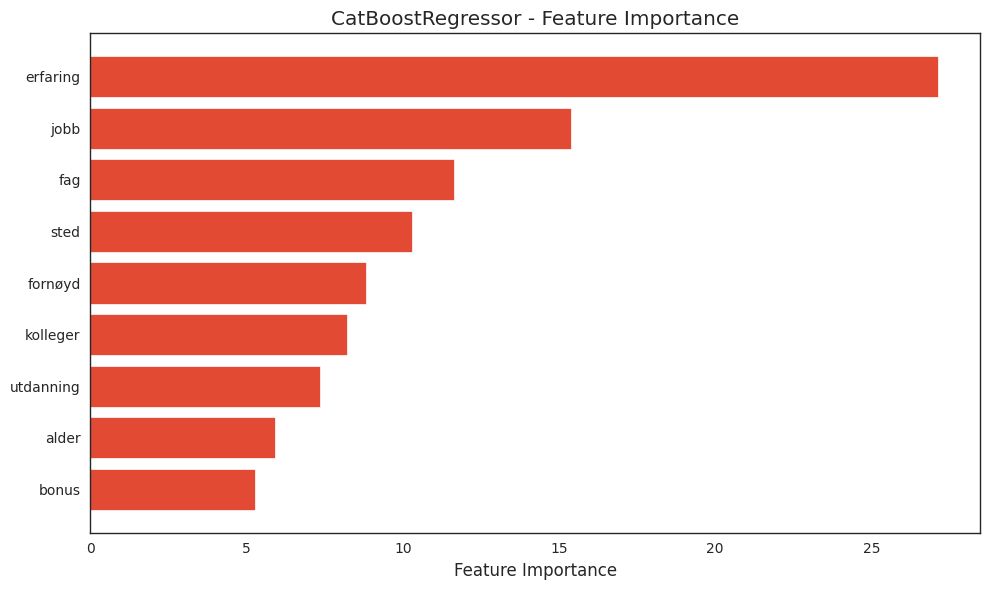

In [23]:
model = CatBoostRegressor(random_state=SEED, verbose=False)
model.fit(X, y)

feature_importances = model.get_feature_importance()
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoostRegressor - Feature Importance')

plt.tight_layout()
plt.show()